# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# [1]. Reading Data

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('./Amazon Fine Food Reviews Analysis/database.sqlite') 
#this opens a connection to database 

#filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3
  
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews 
WHERE Score != 3 
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']           #score column selected
positiveNegative = actualScore.map(partition)  #mapping on the above function
filtered_data['Score'] = positiveNegative      #column with value replaced by +ve and -ve
print("Number of data points in our data", filtered_data.shape)  #5K entries and 10 columns
filtered_data.head(3)


Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
#discover the problem  by writting alot of queries
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

#same timestamp so not possible
#Go to--> www.amazon.com/dp/<product id>
#user review for 1 product(in various flavour) = review for all

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
#dup if user id , profile name , time , text same then keep only ist entry

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator(YES) is greater than HelpfulnessDenominator(YES+NO) which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

#HelpfulnessNumerator < HelpfulnessDenominator -->ALWAYS

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
#remove not logically correct data
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500) 
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [11]:
# remove urls from text python: 
#https://stackoverflow.com/a/40823105/4084039
import re #re --> regular expressions
sent_0 = re.sub(r"http\S+", "", sent_0)
#removes any URLs (strings starting with "http" followed by non-whitespace characters)
#from the sent_0 string by replacing them with an empty string.
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_1500 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)
print("="*50)
print(sent_1000)
print("="*50)
print(sent_1500)
print("="*50)
print(sent_4900)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [12]:
# how to remove all tags from an element? 
#https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [13]:
#Expanding English language contractions in Python
#https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [15]:
# lets search the string already present before in the notebook
# print(final[final['Text'].str.contains("but these reviews do nobody any good beyond reminding")]['Text'])
sent_291694 = final['Text'][291694]
sent_291694 = re.sub(r"https?:\/\/[^\s]+", "", sent_291694)
soup = BeautifulSoup(sent_291694, 'lxml')
sent_291694 = soup.get_text()
sent_291694 = decontracted(sent_291694)
print(sent_291694)
print("="*50)
print(final['Text'][291694])
# don't like becomes do not like etc, etc

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh yeah, chocolate chip cook

In [16]:
#remove words with numbers python:
#https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
#removing words like "abc123def").
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
#remove spacial character: 
#https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
review_score = []    # Storing score for later
# tqdm is for printing the status bar
for sentence, score in tqdm(final[['Text', 'Score']].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)   # adding 0-9 in the regex
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    review_score.append(score)

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [05:42<00:00, 1062.81it/s]


In [20]:
print(len(preprocessed_reviews))
print(len(review_score))
print(review_score[:5])

364171
364171
['positive', 'positive', 'positive', 'positive', 'positive']


In [21]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [22]:
# just trying to find the review which was there in the notebook before

preprocessed_reviews.index([stri for stri in preprocessed_reviews if 'obviously no idea ordering wants crispy cookies hey sorry' in stri][0])

62532

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [23]:
## Similarly you can do preprocessing for review summary also.

In [24]:
preprocessed_summary = []
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z0-9]+', ' ', summary)   # adding 0-9 in the regex
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:36<00:00, 1683.01it/s]


In [25]:
preprocessed_summary[60200]

'yummy healthier gummies'

In [26]:
# deleting to free system memory
del preprocessed_summary

# [4] Featurization

# Data selection

In [27]:
# Lets reduce the size of pre-processed reviews to 5K considering the system RAM

# len(preprocessed_reviews) - 348260

choice = np.arange(len(preprocessed_reviews))
np.random.shuffle(choice)
# print(len([preprocessed_reviews[i] for i in choice[:5]]))
preprocessed_reviews = [preprocessed_reviews[i] for i in choice[:5000]]
review_score = [review_score[i] for i in choice[:5000]]
print(len(preprocessed_reviews))
print(len(review_score))

5000
5000


In [28]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer(max_features=5000) #() #in scikit-learn
final_counts = count_vect.fit_transform(preprocessed_reviews)

print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [30]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation 
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice


count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 3152)
the number of unique words including both unigrams and bigrams  3152


## [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
final_tf_idf = tf_idf_vect.fit_transform(preprocessed_reviews)

print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 3152)
the number of unique words including both unigrams and bigrams  3152


## [4.4] Word2Vec

In [32]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

from gensim.models import *
import pickle

#w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

#w2v_model.wv.similarity('women','man')  
#w2v_model.wv.similarity('man','man') #--> o/p 1.0

#print(w2v_model.wv.most_similar('great')) #gives dec order list of word similar to great
#print(w2v_model.wv.most_similar('worst')) #gives dec order list of word similar to worst


    

# [4.4] Word2Vec OWN MODEL

In [33]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [34]:
print(preprocessed_reviews[1500])
print("***************************************************************************")
print(list_of_sentance[1500])

say tastes good probably tons unhealthy ingredients bad tastes good nice chocolatey outside nice creamy filling inside
***************************************************************************
['say', 'tastes', 'good', 'probably', 'tons', 'unhealthy', 'ingredients', 'bad', 'tastes', 'good', 'nice', 'chocolatey', 'outside', 'nice', 'creamy', 'filling', 'inside']


In [35]:
import os
import gensim
from gensim import models
from gensim.models import Word2Vec, KeyedVectors

In [36]:
w2v_model_own=gensim.models.Word2Vec(list_of_sentance,min_count=5,vector_size=50,workers=2)

#min_count--> if the word doesnt occur atlest 5 time dont make word to vector
#size--> dimenional vector 50
#workers=4 --> use all 4 cores

In [37]:
w2v_words = list(w2v_model_own.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))

print("***************************************************************************")

print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4150
***************************************************************************
sample words  ['not', 'like', 'good', 'great', 'one', 'taste', 'product', 'would', 'tea', 'flavor', 'coffee', 'love', 'no', 'get', 'really', 'amazon', 'food', 'time', 'much', 'best', 'use', 'find', 'little', 'price', 'make', 'buy', 'also', 'tried', 'well', 'even', 'try', 'better', 'chocolate', 'eat', 'used', 'sugar', 'first', 'water', 'found', 'made', 'could', 'bought', 'box', 'sweet', 'bag', 'dog', 'drink', 'two', 'free', 'cup']


In [38]:
similar_words = w2v_model_own.wv.most_similar('tasty')
print(similar_words)

[('chips', 0.9974600672721863), ('sounds', 0.9972915053367615), ('consistency', 0.9970943331718445), ('dressing', 0.9970905780792236), ('crunch', 0.9970375299453735), ('overall', 0.9969920516014099), ('horrible', 0.9969838857650757), ('cereal', 0.9969804286956787), ('matter', 0.9969533681869507), ('crunchy', 0.996936023235321)]


In [39]:
w2v_model_own.wv.most_similar('like')

[('taste', 0.9906045794487),
 ('flavor', 0.9901046752929688),
 ('tastes', 0.9886677265167236),
 ('strong', 0.9857074618339539),
 ('sweet', 0.9836399555206299),
 ('bitter', 0.973544716835022),
 ('drink', 0.9724063873291016),
 ('nice', 0.9716955423355103),
 ('smooth', 0.9687005281448364),
 ('dark', 0.9673988223075867)]

In [40]:
count_vect_feat=count_vect.get_feature_names_out()
index_of_like = np.where(count_vect_feat == 'like')[0][0]
print(count_vect_feat[index_of_like])

like


# [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

# [4.4.1.1] Avg W2v

In [41]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_own.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 505.32it/s]

5000
50


# [4.4.1.2] TFIDF weighted W2v

In [42]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

In [43]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model_own.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:30<00:00, 33.14it/s]


In [44]:
# deleting the word2Vec model to free RAM

del w2v_model_own

# [5] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

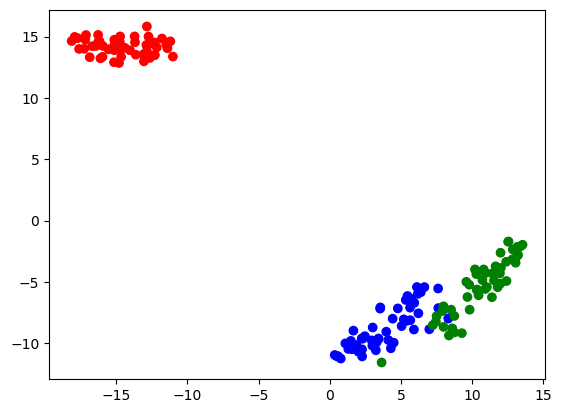

In [47]:
# https://github.com/pavlin-policar/fastTSNE
from openTSNE import TSNE
from sklearn import datasets

iris = datasets.load_iris()
x, y = iris['data'], iris['target']

# print(len(x), len(y))

tsne = TSNE( n_components=2, perplexity=30, learning_rate=200, n_jobs=4,initialization='pca',\
            metric='euclidean', early_exaggeration_iter=250, early_exaggeration=12, n_iter=750)

X_embedding = tsne.fit(x)

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

# [5.1] Applying TNSE on Text BOW vectors

In [53]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

    
# Using multiCore tSNE as openTSNE is causing system to crash
# https://github.com/DmitryUlyanov/Multicore-TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]
print('2-D representation of BOW vectors using TSNE')

for perplexity in perplexity_values:
    for iteration in iteration_values:

        # converting the count vectors to sparse matrix form
        x, y = final_counts.A, review_score
        
        #The .A attribute is commonly used with sparse matrices 
        #to retrieve the dense representation of the matrix.
        
        # setting up TSNE model
        X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,
                           n_iter=iteration, n_jobs=5).fit_transform(x) 
        
        # creating a new data fram which help us in ploting the result data
        tsne_data = np.vstack((X_embedding.T, y)).T
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

        sns.set_style("whitegrid");
        sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
           .map(plt.scatter, "Dimension_X", "Dimension_Y") \
           .add_legend();
        plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
        plt.show(); 


ModuleNotFoundError: No module named 'MulticoreTSNE'

# [5.1] Applying TNSE on Text TFIDF vectors

In [51]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]
print('2-D representation of Tf-IDF vectors using TSNE')

for perplexity in perplexity_values:
    for iteration in iteration_values:

        # converting the count vectors to sparse matrix form
        x, y = final_tf_idf.A, review_score
        
        # setting up TSNE
        X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,
                           n_iter=iteration, n_jobs=4).fit_transform(x) 
        
        # creating a new data fram which help us in ploting the result data
        tsne_data = np.vstack((X_embedding.T, y)).T
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

        sns.set_style("whitegrid");
        sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
           .map(plt.scatter, "Dimension_X", "Dimension_Y") \
           .add_legend();
        plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
        plt.show(); 

2-D representation of Tf-IDF vectors using TSNE


AttributeError: 'TSNE' object has no attribute 'fit_transform'

# [5.3] Applying TNSE on Text Avg W2V vectors

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]
print('2-D representation of W2V vectors using TSNE')

for perplexity in perplexity_values:
    for iteration in iteration_values:

        # converting the count vectors to sparse matrix form
        x, y = np.array(sent_vectors), review_score
        
        # setting up TSNE
        X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,
                           n_iter=iteration, n_jobs=4).fit_transform(x) 
        
        # creating a new data fram which help us in ploting the result data
        tsne_data = np.vstack((X_embedding.T, y)).T
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

        sns.set_style("whitegrid");
        sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
           .map(plt.scatter, "Dimension_X", "Dimension_Y") \
           .add_legend();
        plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
        plt.show(); 

# [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]
print('2-D representation of Tf-IDF weighted W2V vectors using TSNE')

for perplexity in perplexity_values:
    for iteration in iteration_values:

        # converting the to matrix form
        x, y = np.array(tfidf_sent_vectors), review_score
        
        # setting up TSNE
        X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,
                           n_iter=iteration, n_jobs=4).fit_transform(x) 
        
        # creating a new data fram which help us in ploting the result data
        tsne_data = np.vstack((X_embedding.T, y)).T
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

        sns.set_style("whitegrid");
        sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
           .map(plt.scatter, "Dimension_X", "Dimension_Y") \
           .add_legend();
        plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
        plt.show(); 

In [ ]:
# trying Tf_IDF weighted W2V with perplexity = 800 on high value of iterations
x, y = np.array(tfidf_sent_vectors), review_score

# setting up TSNE
X_embedding = TSNE(n_components=2, random_state=0, perplexity=800,
                   n_iter=5000, n_jobs=4).fit_transform(x) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((X_embedding.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

sns.set_style("whitegrid");
sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
   .map(plt.scatter, "Dimension_X", "Dimension_Y") \
   .add_legend();
plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
plt.show(); 

In [ ]:
# trying on bigrams with perplexity = 500 on high value of iterations
x, y = final_bigram_counts.A, review_score

# setting up TSNE
X_embedding = TSNE(n_components=2, random_state=0, perplexity=500,
                   n_iter=5000, n_jobs=4).fit_transform(x) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((X_embedding.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

sns.set_style("whitegrid");
sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
   .map(plt.scatter, "Dimension_X", "Dimension_Y") \
   .add_legend();
plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
plt.show(); 

# [6] Conclusions

* For the BOW vectorization we do not get a good representation of data as it is a simple count based technique. Although we see some grouping shows up in this but that is only for small value of perplexity (neighbourhood). There is no consideration of meanings or symantic similarity in BOW

* The Tf-IDF representation proves to be much better as compared to the BOW representation as it tries to focus on the unique words from the corpus rather than simple count based scoring. On smaller values of perlexity it is successfully able to single out the negative reviews

* As for the average word2Vec representation, theoretically it should beat the above two representations with ease but in almost all the observations we see the positive reviews scattered uniformly with the negative reviews dotting the plot in random positions. Although for large values of perplexity and iterations we see a shift in the position of negative reviews to upper region of the plot.

* As for the Tf-IDF weighted word2Vec representation we do not see any significant improvement from the average word2Vec.

**We know the word2Vec to be one of the best representations, but we do not see it helping to demarcate the positive and negative reviews very prominently, in this experiment. One reason we can point out for this is that possibly 50 dims is far too less to catch the entire information, and applying TSNE after that further cause info loss. We are unable to increase dimensions due to hardware constraints.**

* We even tries TSNE on bigrams as test. It was successfully able to create a cluster of very small groups throughout the plot, while the negative reviews were focussed mainly on the top region of the plot. 
